In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [220]:
df = pd.read_csv('Preprocessed_data.csv')


df.index = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.drop(['Date', 'Salmon_exp_price'], axis=1, inplace=True)

In [221]:
y = df['Salmon_exp_vol']
X = df.loc[:,'FX_EURONOK':]

In [339]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.2,
                                                    shuffle=False)

In [286]:
# Log transform  the FX columns
def log_transform(X_train, X_test, y_train, y_test):
    X_train = np.log(X_train['FX_EURONOK'])
    X_test = np.log(X_test['FX_EURONOK'])
    return [X_train, X_test, y_train, y_test]

In [269]:
from sklearn.impute import KNNImputer

In [289]:
def nan_imputer(X_train, X_test, y_train, y_test):
    data = [X_train, X_test, y_train, y_test]
    for i in range(0,2,2):
        imputer = KNNImputer(n_neighbors=5, weights='uniform')
        data[i+i*2] = imputer.fit_transform(data[i+i*2])
        data[i+1+i*2] = imputer.transform(data[i+1+i*2])
    
    return data


In [345]:
def normalization(X_train, X_test, y_train, y_test):

    data = [X_train, X_test, y_train, y_test]
    for i in range(0,2,2):
        normalizer = StandardScaler()
        data[i+i*2] = normalizer.fit_transform(data[i+i*2]['FX_EURONOK'])
        data[i+i*2] = normalizer.transform(data[i+1+i*2]['FX_EURONOK'])
    
    return data

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.2,
                                                    shuffle=False)

# Manual change in FX column
X_train['FX_EURONOK']['2002-10-14'] = 7.34

In [347]:
X_train, X_test, y_train, y_test = log_transform(X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = nan_imputer(X_train, X_test, y_train, y_test)

ValueError: Expected a 2-dimensional container but got <class 'pandas.core.series.Series'> instead. Pass a DataFrame containing a single row (i.e. single sample) or a single column (i.e. single feature) instead.

In [245]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Activation

In [226]:
X_train.shape[0]

960

In [227]:
LSTM1_units = 2
time_steps = 1
features = X_train.shape[1]

In [291]:
def  reshape_for_modelling(X_train, X_test, y_train, y_test):
    inp = [X_train, X_test, y_train, y_test]

    for i in range(0,4,1):
        sel = np.array(inp[i])
        if i >= 2:
            sel = np.array([sel]).T
        print(sel.shape)

        inp[i] = np.reshape(sel, (sel.shape[0], time_steps, sel.shape[1]))
    return inp

In [292]:
X_tr_re, X_te_re, y_tr_re, y_te_re = reshape_for_modelling(X_train, X_test, y_train, y_test)

(960, 3)
(240, 3)
(960, 1)
(240, 1)


In [313]:
model = Sequential()
model.add(LSTM(LSTM1_units,input_shape=(1,3),return_sequences=True))
model.add(Dense(1, activation='relu'))

model.compile(loss ='mae', optimizer='adam')
model.fit(X_tr_re, y_tr_re, epochs=50, batch_size=40, verbose=2)

Epoch 1/50
24/24 - 1s - loss: 11604.3506 - 1s/epoch - 43ms/step
Epoch 2/50
24/24 - 0s - loss: 11604.2676 - 30ms/epoch - 1ms/step
Epoch 3/50
24/24 - 0s - loss: 11604.2100 - 30ms/epoch - 1ms/step
Epoch 4/50
24/24 - 0s - loss: 11604.1631 - 28ms/epoch - 1ms/step
Epoch 5/50
24/24 - 0s - loss: 11604.1191 - 20ms/epoch - 842us/step
Epoch 6/50
24/24 - 0s - loss: 11604.0771 - 28ms/epoch - 1ms/step
Epoch 7/50
24/24 - 0s - loss: 11604.0332 - 21ms/epoch - 886us/step
Epoch 8/50
24/24 - 0s - loss: 11603.9883 - 25ms/epoch - 1ms/step
Epoch 9/50
24/24 - 0s - loss: 11603.9482 - 26ms/epoch - 1ms/step
Epoch 10/50
24/24 - 0s - loss: 11603.9062 - 25ms/epoch - 1ms/step
Epoch 11/50
24/24 - 0s - loss: 11603.8623 - 28ms/epoch - 1ms/step
Epoch 12/50
24/24 - 0s - loss: 11603.8193 - 34ms/epoch - 1ms/step
Epoch 13/50
24/24 - 0s - loss: 11603.7793 - 27ms/epoch - 1ms/step
Epoch 14/50
24/24 - 0s - loss: 11603.7354 - 29ms/epoch - 1ms/step
Epoch 15/50
24/24 - 0s - loss: 11603.6914 - 28ms/epoch - 1ms/step
Epoch 16/50
24/2

In [335]:
history = model.fit(
    X_tr_re, y_train,
    # validation_data=(X_valid, y_valid),
    batch_size=60,
    epochs=100,
    verbose=0,
)

In [336]:
history_df = pd.DataFrame(history.history)
history_df

,loss
0,11591.360352
1,11591.333984
2,11591.306641
3,11591.275391
4,11591.250000
...,...
95,11588.684570
96,11588.655273
97,11588.625977
98,11588.598633


<AxesSubplot:>

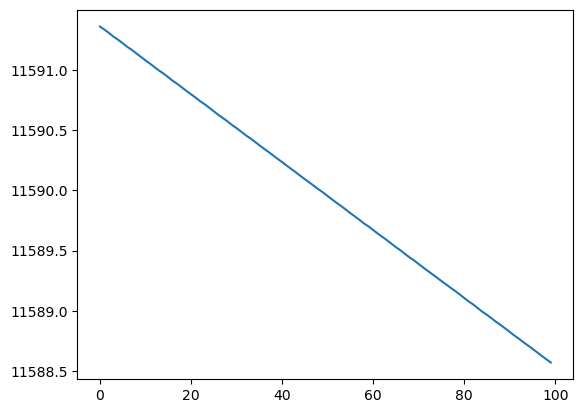

In [337]:
history_df['loss'].plot()

In [328]:
trainPredict = model.predict(X_tr_re)
trainPredict

30/30 [==============================] - 0s 985us/step


array([[[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969868]],

       [[13.969866]],

       [[13.969866]],

       [[13.969866]],

       [[13.969866]],

       [[13.969865]],

       [[13.969865]],

       [[13.969865]],

       [[13.969865]],

       [[13.969865]],

       [[13.969865]],

       [[13.969865]],

       [[13.969865]],

       [[13

In [331]:
trainPredict.flatten()

array([13.969868, 13.969868, 13.969868, 13.969868, 13.969868, 13.969868,
       13.969868, 13.969868, 13.969868, 13.969868, 13.969868, 13.969868,
       13.969868, 13.969868, 13.969868, 13.969868, 13.969868, 13.969868,
       13.969868, 13.969868, 13.969868, 13.969868, 13.969868, 13.969868,
       13.969868, 13.969868, 13.969868, 13.969868, 13.969868, 13.969868,
       13.969868, 13.969866, 13.969866, 13.969866, 13.969866, 13.969865,
       13.969865, 13.969865, 13.969865, 13.969865, 13.969865, 13.969865,
       13.969865, 13.969865, 13.969866, 13.969866, 13.969866, 13.969866,
       13.969866, 13.969866, 13.969866, 13.969866, 13.969866, 13.969863,
       13.969863, 13.969863, 13.969863, 13.969867, 13.969867, 13.969867,
       13.969867, 13.969868, 13.969868, 13.969868, 13.969868, 13.969868,
       13.969868, 13.969868, 13.969868, 13.969868, 13.969869, 13.969869,
       13.969869, 13.969869, 13.969868, 13.969868, 13.969868, 13.969868,
       13.969868, 13.969868, 13.969868, 13.969868, 

In [323]:
from sklearn.metrics import mean_absolute_error as mae

In [333]:
mae(trainPredict.flatten(), y_train)

11591.374923262